In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from copy import deepcopy
from enum import Enum
from contextlib import contextmanager
from typing import Any, Optional, Tuple, Union, Callable
from torch import Tensor


from gpytorch.kernels import MaternKernel
from botorch.sampling.pathwise import draw_matheron_paths
from botorch.models import SingleTaskGP
from botorch.test_functions import Hartmann, Branin

@contextmanager
def torch_random_seed(
        seed: int,
):
    """
    Sets the random seed for torch operations within the context.

    Parameters:
    seed (int): The random seed to be set.

    This function sets the random seed for torch operations within the context. After the context is exited, the random
    seed is reset to its original value.
    """
    torch_state = torch.random.get_rng_state()
    torch.manual_seed(seed)
    try:
        yield
    finally:
        torch.random.set_rng_state(torch_state)


/opt/anaconda3/envs/botorchEnv2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import glob
import json

benchmark = 'prior_sample_2d_ls0.1'

run_dirs = glob.glob('results/ves_log_gp_hps/*')

def general_dir_match(
        args: dict,
):
    if not 'prior_sample' in benchmark:
        return True
    else:
        ls = float(benchmark.split('_')[-1][2:])
        set_ls = args['set_lengthscale'] 
        return set_ls is None# and float(ls) == float(set_ls)

relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]

def def_dir_match(
        args: dict
):
    return args['clamp_min'] == 1e-10 \
        and args['sample_around_best'] == True \
        and args['acqf_raw_samples'] == 512 \
        and args['num_paths'] == 64 \
        and args['num_iter'] == 50


ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
# remove ei_dirs from relevant_dirs
relevant_dirs = [d for d in relevant_dirs if d not in ei_dirs]
relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]

default_dirs = [d for d in relevant_dirs if def_dir_match(json.load(open(f'{d}/args.json'))) and 'train_x_ves.npy' in d]

num_paths = [256]
ablation_dirs = [d for d in relevant_dirs if
                    json.load(open(f'{d}/args.json'))['num_paths'] in num_paths] + default_dirs
ablation_hashes = list(set([int(d.split('/')[-1].split('_')[1]) for d in ablation_dirs]))

for h in ablation_hashes:
    dirs = [d for d in ablation_dirs if int(d.split('/')[-1].split('_')[1]) == h]
    ves_x = [np.load(f'{d}/train_x_ves.npy') for d in dirs]
    ei_x = [np.load(f'{d}/train_x_ei.npy') for d in ei_dirs]
    mes_x = [np.load(f'{d}/train_x_mes.npy') for d in mes_dirs]
    


In [3]:
class BenchmarkType(Enum):
    BOTORCH = 1
    BENCHER = 2
    GP_PRIOR_SAMPLE = 3

def get_objective(
        benchmark_name: str,
) -> Tuple[Callable[[Tensor], Tensor], int]:
    """

    Args:
        benchmark_name (str): the name of the benchmark

    Returns:
        Tuple[Callable[[Tensor], Tensor], int]: the objective function and the dimensionality of the problem

    """

    match benchmark_name:
        case 'branin2':
            benchmark_dim = 2
            benchmark_type = BenchmarkType.BOTORCH
        case s if s.startswith('prior_sample_'):
            benchmark_dim = int(s.split('_')[2][:-1])
            sample_ls = float(s.split('_')[-1][2:])
            benchmark_type = BenchmarkType.GP_PRIOR_SAMPLE
        case _:
            raise ValueError("Invalid benchmark")

    def objective(
            x: Tensor,
    ) -> Tensor:
        """
        The objective function

        Args:
            x: the input

        Returns:
            Tensor: the output

        """
        if benchmark_type == BenchmarkType.BOTORCH:
            if benchmark == 'hartmann6':
                _f = Hartmann(negate=True)
                return _f(x)
            elif benchmark == 'branin2':

                branin_bounds = torch.tensor([[-5, 10], [0, 15]])
                x_eval = x * (branin_bounds[1] - branin_bounds[0]) + branin_bounds[0]

                _f = Branin(negate=True)
                return _f(x_eval)
        elif benchmark_type == BenchmarkType.GP_PRIOR_SAMPLE:
            prior_sample_gp_covar_module = MaternKernel(
                nu=2.5,
                ard_num_dims=benchmark_dim,
            )
            prior_sample_gp_covar_module.lengthscale = torch.tensor(sample_ls)
            prior_sample_gp = SingleTaskGP(
                torch.empty(0, benchmark_dim, dtype=torch.double),
                torch.empty(0, 1, dtype=torch.double),
                covar_module=prior_sample_gp_covar_module,
            )

            with torch_random_seed(42):
                prior_sample_gp_path = draw_matheron_paths(
                    model=deepcopy(prior_sample_gp),
                    sample_shape=torch.Size([1]),
                )
            return prior_sample_gp_path(x.detach().reshape(1, -1)).detach().squeeze()
        else:
            raise ValueError("Invalid benchmark type")

    return objective, benchmark_dim

objective, benchmark_dim = get_objective(benchmark)

In [4]:
# Global parameters
BOUNDS = torch.zeros(2,2)
BOUNDS[:, 1] = torch.ones(2)
NUM_TRIALS = 10
NUM_ITER = 100
NUM_PATHS = 64
# 2D discretization parameters
nx = 101
ny = 101
# Create meshgrid for 2D discretization
x = np.linspace(BOUNDS[0, 0].item(), BOUNDS[0, 1].item(), nx)
y = np.linspace(BOUNDS[1, 0].item(), BOUNDS[1, 1].item(), ny)
X, Y = np.meshgrid(x, y)
Z = np.array([[objective(torch.tensor([xi, yi])) for xi, yi in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

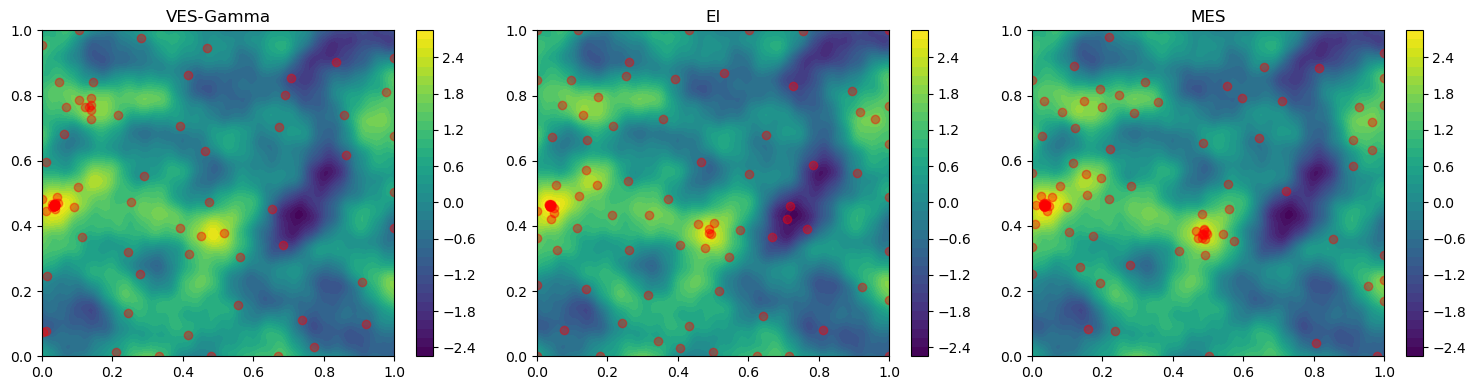

In [14]:
# Create three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
M = 100
idx = 0
# Plot 1: 
cp1 = axs[0].contourf(X, Y, Z, levels=50, cmap='viridis')
fig.colorbar(cp1, ax=axs[0])
axs[0].scatter(ves_x[idx][:M, 0], ves_x[idx][:M, 1], color='red', alpha=0.4)
axs[0].set_title('VES-Gamma')

# Plot 2: 
cp2 = axs[1].contourf(X, Y, Z, levels=50, cmap='viridis')
fig.colorbar(cp2, ax=axs[1])
axs[1].scatter(ei_x[idx][:M, 0], ei_x[idx][:M, 1], color='red', alpha=0.4)
axs[1].set_title('EI')

# Plot 3: 
cp3 = axs[2].contourf(X, Y, Z, levels=50, cmap='viridis')
fig.colorbar(cp3, ax=axs[2])
axs[2].scatter(mes_x[idx][:M, 0], mes_x[idx][:M, 1], color='red', alpha=0.4)
axs[2].set_title('MES')

# Adjust layout
plt.tight_layout()
plt.show()